In [1]:
import os
import random


In [ ]:
import numpy as np
import time
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import Lambda
from torch.cuda.amp import GradScaler, autocast
from torchviz import make_dot

from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
ime
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import Lambda
from torch.cuda.amp import GradScaler, autocast
from torchviz import make_dot

from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

import pandas as pd
import matplotlib.pyplot as plt

In [2]:
print(torch.version.cuda)

print("GPU Available: ", torch.cuda.is_available())

if torch.cuda.is_available():
    print("GPU is available.")
else:
    print("GPU is not available.")



11.7
GPU Available:  True
GPU is available.


In [3]:
torch.cuda.empty_cache()


##### Construct Rain100L Dataset - Load both Rainy and Norainy images

In [84]:
# # Set a random seed
# random.seed(42)

# # Shuffle the norain_files and rain_files before splitting
# random.shuffle(norain_files)
# random.shuffle(rain_files)

# data_path = "Rain100L"
# norain_files = sorted(os.listdir(data_path))
# rain_files = sorted(os.listdir(os.path.join(data_path, "rainy")))

# # Split the dataset
# split = (0.7, 0.2, 0.1)
# total = len(norain_files)
# train_idx = int(total * split[0])
# val_idx = int(total * (split[0] + split[1]))

# train_files = norain_files[:train_idx]
# val_files = norain_files[train_idx:val_idx]
# test_files = norain_files[val_idx:]

# # 2. Create the dataset loader for training, validation, and test sets

# class RainDataset(Dataset):
#     def __init__(self, data_path, norain_files, rain_files, transform=None):
#         self.data_path = data_path
#         self.norain_files = norain_files
#         self.rain_files = rain_files
#         self.transform = transform

#     def __len__(self):
#         return len(self.norain_files)

#     def __getitem__(self, idx):
#         norain_img = Image.open(os.path.join(self.data_path, self.norain_files[idx]))
#         rain_img = Image.open(os.path.join(self.data_path, "rainy", self.rain_files[idx]))

#         if self.transform:
#             norain_img = self.transform(norain_img)
#             rain_img = self.transform(rain_img)

#         return rain_img, norain_img

# transform = transforms.Compose([transforms.ToTensor()])

# train_dataset = RainDataset(data_path, train_files, rain_files[:train_idx], transform)
# val_dataset = RainDataset(data_path, val_files, rain_files[train_idx:val_idx], transform)
# test_dataset = RainDataset(data_path, test_files, rain_files[val_idx:], transform)

# train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


In [4]:
class Rain100L_Dataset(Dataset):
    def __init__(self, rainy_path, norainy_path, data, transform=None):
        self.rainy_path = rainy_path
        self.norainy_path = norainy_path
        self.data = data
        self.transform = transform
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        rainy_img_name, norainy_img_name = self.data[idx]
        rainy_image = Image.open(os.path.join(self.rainy_path, rainy_img_name))
        norainy_image = Image.open(os.path.join(self.norainy_path, norainy_img_name))

        if self.transform:
            rainy_image = self.transform(rainy_image)
            norainy_image = self.transform(norainy_image)

        return rainy_image, norainy_image


##### First implementation idea for splitting

In [5]:
def split_data(rainy_path, norainy_path, train_ratio=0.7, val_ratio=0.2, test_ratio=0.1):
    # Set a random seed
    random.seed(42)

    rainy_files = sorted(os.listdir(rainy_path))
    norainy_files = sorted(os.listdir(norainy_path))
    
    data_size = len(rainy_files)
    indices = list(range(data_size))
    random.shuffle(indices)

    train_indices = indices[:int(data_size * train_ratio)]
    val_indices = indices[int(data_size * train_ratio):int(data_size * (train_ratio + val_ratio))]
    test_indices = indices[int(data_size * (train_ratio + val_ratio)):]

    train_data = [(rainy_files[i], norainy_files[i]) for i in train_indices]
    val_data = [(rainy_files[i], norainy_files[i]) for i in val_indices]
    test_data = [(rainy_files[i], norainy_files[i]) for i in test_indices]

    return train_data, val_data, test_data


### Split the data and create data loaders

In [6]:
def resize_and_pad(target_width, target_height):
    def _resize_and_pad(image):
        aspect_ratio = image.width / image.height
        if aspect_ratio > 1:  # width > height
            new_width = target_width
            new_height = int(new_width / aspect_ratio)
        else:  # height >= width
            new_height = target_height
            new_width = int(new_height * aspect_ratio)

        resized_image = image.resize((new_width, new_height), Image.BICUBIC)

        padded_image = Image.new('RGB', (target_width, target_height), color=0)
        left_padding = (target_width - new_width) // 2
        top_padding = (target_height - new_height) // 2
        padded_image.paste(resized_image, (left_padding, top_padding))
        return padded_image

    return _resize_and_pad

In [7]:
rainy_path = r"G:\\My Drive\Deraining\\Rain100L\\rainy"
norainy_path = r"G:\\My Drive\\Deraining\\Rain100L"


train_data, val_data, test_data = split_data(rainy_path, norainy_path)

target_width = 480
target_height = 320
transform = transforms.Compose([
    Lambda(resize_and_pad(target_width, target_height)),
    transforms.ToTensor()
])

train_set = Rain100L_Dataset(rainy_path, norainy_path, train_data, transform)
val_set = Rain100L_Dataset(rainy_path, norainy_path, val_data, transform)
test_set = Rain100L_Dataset(rainy_path, norainy_path, test_data, transform)

train_loader = DataLoader(train_set, batch_size=4, shuffle=True)
val_loader = DataLoader(val_set, batch_size=4, shuffle=False)
test_loader = DataLoader(test_set, batch_size=4, shuffle=False)



In [ ]:
# train_loader = DataLoader(train_set, batch_size=4, shuffle=True, num_workers=2)
# val_loader = DataLoader(val_set, batch_size=4, shuffle=False, num_workers=2)
# test_loader = DataLoader(test_set, batch_size=4, shuffle=False, num_workers=2)



# train_loader = DataLoader(train_set, batch_size=16, shuffle=True, num_workers=0)
# val_loader = DataLoader(val_set, batch_size=16, shuffle=False, num_workers=0)
# test_loader = DataLoader(test_set, batch_size=1, shuffle=False, num_workers=0)

### U-Net Implementation for Rain100L DataSet

##### implementation for images of size 481x321 with RGB channels 

##### This U-Net architecture has 4 downsampling and 4 upsampling layers, which works for input images with dimensions of 481x321. The input and output channels are set to 3 to accommodate RGB images.

In [8]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )

        def up_block(in_channels, out_channels):
            return nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
                nn.ReLU(inplace=True)
            )

        self.enc1 = conv_block(in_channels, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)
        self.enc4 = conv_block(256, 512)

        self.pool = nn.MaxPool2d(2)
        
        self.middle = conv_block(512, 1024)

        self.up4 = up_block(1024, 512)
        self.dec4 = conv_block(1024, 512)
        self.up3 = up_block(512, 256)
        self.dec3 = conv_block(512, 256)
        self.up2 = up_block(256, 128)
        self.dec2 = conv_block(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = conv_block(128, 64)

        self.output = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))

        middle = self.middle(self.pool(enc4))

        up4 = self.up4(middle)
        merge4 = torch.cat([enc4, up4], dim=1)
        dec4 = self.dec4(merge4)

        up3 = self.up3(dec4)
        merge3 = torch.cat([enc3, up3], dim=1)
        dec3 = self.dec3(merge3)

        up2 = self.up2(dec3)
        merge2 = torch.cat([enc2, up2], dim=1)
        dec2 = self.dec2(merge2)

        up1 = self.up1(dec2)
        merge1 = torch.cat([enc1, up1], dim=1)
        dec1 = self.dec1(merge1)

        output = self.output(dec1)
        return output

unet = UNet(3, 3)  # Adjust input and output channels to 3 for RGB images


### Visualization in PyTorch


In [9]:


# Create a dummy input tensor with the same shape as your input data
dummy_input = torch.randn(1, 3, 480, 320)  # Adjust the shape as needed

# Move the model and dummy input to the device (either GPU or CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
unet = UNet(3, 3).to(device)
dummy_input = dummy_input.to(device)

# Run the model with the dummy input and visualize the model architecture
output = unet(dummy_input)
dot = make_dot(output, params=dict(unet.named_parameters()))
dot.format = 'png'
dot.render('unet')


'unet.png'

### Visualization in Netron

In [16]:
import torch.onnx

dummy_input = torch.randn(1, 3, 480, 320)
dummy_input = dummy_input.to(device)

torch.onnx.export(unet, dummy_input, "unet.onnx", opset_version=11)


================ Diagnostic Run torch.onnx.export version 2.0.0 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [75]:
# rainy_path = 'Rain100L/rainy'
# norainy_path = 'Rain100L'

In [76]:
# # Set the device index to the desired GPU (0 for the first GPU, 1 for the second, etc.)
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# # Now you can move your model and data to the selected device
# model = unet.to(device)
# data = unet.to(device)

##### To train, validate, and test the U-Net model on the Rain100L dataset 
1. Prepare the dataset and split it into training, validation, and test sets. 
2. Create the dataset loader for training, validation, and test sets.
3. Train the model on the training set and validate on the validation set.
4. Test the model on the test set, compute the evaluation metrics (PSNR and SSIM), and save the derained images.


In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
unet = UNet(3, 3).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(unet.parameters(), lr=0.001)

num_epochs = 200

In [10]:


# Initialize gradient scaler for mixed-precision training
scaler = GradScaler()
accumulation_steps = 4

# Initialize lists to store train and validation losses
train_losses = []
val_losses = []

print('--- Training starts! ---')
start_time_train = time.time()

for epoch in range(num_epochs):
    unet.train()
    train_loss = 0.0

    start_time_train_epoch = time.time()
    
    optimizer.zero_grad()
    
    for step, (rain, norain) in enumerate(train_loader):
        rain = rain.to(device)
        norain = norain.to(device)

        # Use autocast for mixed-precision training
        with autocast():
            output = unet(rain)
            loss = criterion(output, norain)
        
        # Scale the loss and backpropagate
        scaler.scale(loss).backward()
        
        if (step + 1) % accumulation_steps == 0:
            # Update the model weights and optimizer state
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
        
        train_loss += loss.item()
    
    # Calculate the average loss for the epoch and append it to the list
    train_losses.append(train_loss/len(train_loader))

    end_time_train_epoch = time.time() - start_time_train_epoch
    
    unet.eval()
    val_loss = 0.0
    
    start_time_val_epoch = time.time()

    with torch.no_grad():
        for rain, norain in val_loader:
            rain = rain.to(device)
            norain = norain.to(device)

            with autocast():
                output = unet(rain)
                loss = criterion(output, norain)

            val_loss += loss.item()

    val_losses.append(val_loss/len(val_loader))
    end_time_val_epoch = time.time() - start_time_val_epoch

    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_losses[-1]:.6f}, Val loss: {val_losses[-1]:.6f}")
    print(f"Epoch {epoch+1} - Training time: {end_time_train_epoch:.4f} seconds, Validation time: {end_time_val_epoch:.4f} seconds")

end_time_train = time.time() - start_time_train
print('Training time: {0:.4f} seconds'.format(end_time_train))


--- Training starts! ---
Epoch 1/200 - Train loss: 0.516684, Val loss: 1.293363
Epoch 1 - Training time: 7.4742 seconds, Validation time: 0.8394 seconds
Epoch 2/200 - Train loss: 0.587318, Val loss: 0.080032
Epoch 2 - Training time: 4.5491 seconds, Validation time: 0.8012 seconds
Epoch 3/200 - Train loss: 0.107186, Val loss: 0.123675
Epoch 3 - Training time: 4.5100 seconds, Validation time: 0.8062 seconds
Epoch 4/200 - Train loss: 0.138391, Val loss: 0.128013
Epoch 4 - Training time: 4.5250 seconds, Validation time: 0.8152 seconds
Epoch 5/200 - Train loss: 0.120936, Val loss: 0.057678
Epoch 5 - Training time: 4.5831 seconds, Validation time: 0.8172 seconds
Epoch 6/200 - Train loss: 7.664582, Val loss: 9.707222
Epoch 6 - Training time: 4.5890 seconds, Validation time: 0.8272 seconds
Epoch 7/200 - Train loss: 2.357773, Val loss: 0.143905
Epoch 7 - Training time: 4.6080 seconds, Validation time: 0.8207 seconds
Epoch 8/200 - Train loss: 0.156270, Val loss: 0.153737
Epoch 8 - Training time:

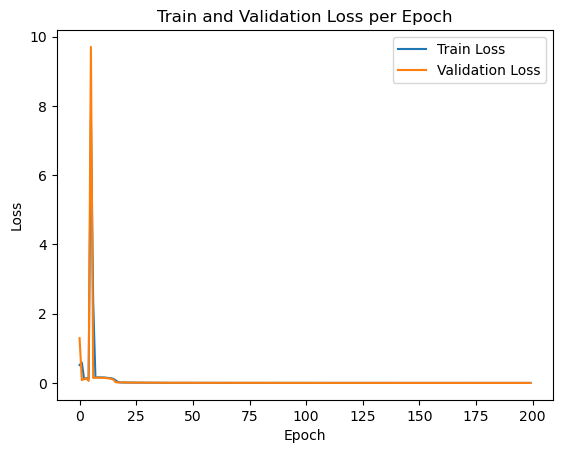

In [11]:
plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train and Validation Loss per Epoch')
plt.savefig('train_val_loss_plot.png')
plt.show()


In [26]:
# unet.eval()
# test_loss = 0.0

# with torch.no_grad():
#     for rain, norain in test_loader:
#         rain = rain.to(device)
#         norain = norain.to(device)

#         with autocast():
#             output = unet(rain)
#             loss = criterion(output, norain)

#         test_loss += loss.item()

# print(f"Test loss: {test_loss/len(test_loader):.6f}")


Test loss: 0.003194


In [12]:
# Test the model and save derained images
print('--- Testing starts! ---')
start_time_test = time.time()

unet.eval()
test_psnr = 0.0
test_ssim = 0.0
output_path = "G:\My Drive\Deraining\Rain100L\derained"
if not os.path.exists(output_path):
    os.makedirs(output_path)
metrics = []
with torch.no_grad():
    img_count = 1
    for i, (rain, norain) in enumerate(test_loader):
        rain = rain.to(device)
        norain = norain.to(device)

        output = unet(rain)
        output = output.cpu().numpy().transpose((0, 2, 3, 1)).clip(0, 1)
        norain = norain.cpu().numpy().transpose((0, 2, 3, 1)).clip(0, 1)

        for j in range(output.shape[0]):
            # Save the derained image
            output_img = Image.fromarray((output[j] * 255).astype(np.uint8))
            output_img.save(os.path.join(output_path, f"derained_{img_count}.png"))

            # Compute PSNR and SSIM
            cur_psnr = psnr(norain[j], output[j], data_range=1)
            cur_ssim = ssim(norain[j], output[j], data_range=1, multichannel=True)

            metrics.append([cur_psnr, cur_ssim])
            img_count += 1

# Save the metrics to a CSV file and compute the average and standard deviation
metrics_df = pd.DataFrame(metrics, columns=["PSNR", "SSIM"])
metrics_df.to_csv("metrics.csv", index=False)

mean_psnr = metrics_df["PSNR"].mean()
mean_ssim = metrics_df["SSIM"].mean()
std_psnr = metrics_df["PSNR"].std()
std_ssim = metrics_df["SSIM"].std()

print(f"Average PSNR: {mean_psnr:.6f} (std: {std_psnr:.6f}), Average SSIM: {mean_ssim:.6f} (std: {std_ssim:.6f})")

--- Testing starts! ---


C:\Users\labuser\AppData\Local\Temp\ipykernel_12516\1426726481.py:29: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  cur_ssim = ssim(norain[j], output[j], data_range=1, multichannel=True)


Average PSNR: 31.586683 (std: 1.746064), Average SSIM: 0.904121 (std: 0.062635)
